In [1]:
using Plots
using LinearAlgebra
using Revise
using Optim
using Zygote
using LaTeXStrings
using MultiFloats
using SparseIR
using Nevanlinna

┌ Info: Precompiling Nevanlinna [0b21cfa8-e591-48a4-a07b-a9d20be7c264]
└ @ Base loading.jl:1662


In [2]:
T = BigFloat

BigFloat

In [3]:
beta::Float64 = 100
wmax::Float64 = 100
basis = FiniteTempBasisSet(Float64(beta), Float64(wmax), 1e-15) 

FiniteTempBasisSet with β = 100.0, ωmax = 100.0

In [4]:
include("../flex_src/IRFLEX.jl")

Main.IRFLEX

In [5]:
nsize::Int64 = 128
#t_pra::Float64 = 0.0375
t_pra::Float64 = 0.0
filling::Float64 = 1.0
U::Float64 = 0.2 ##w=1
function single_Hami(x::Float64, y::Float64, t::Float64, t_pra::Float64)::Float64
    e::Float64 = -2.0*t*(cos(x)+cos(y)) + 4.0*t_pra*cos(x)*cos(y)                   
end
hami::Function = (x,y) -> single_Hami(x,y,0.125,t_pra)
#U::Float64 = 0.5
#hami::Function = (x,y) -> IRFLEX.single_Hami(x,y,t_pra)
lat = IRFLEX.SingleLatticeModel(nsize, filling, U, SparseIR.β(basis), hami)
;

In [6]:
mixing = 0.4   #ratio of mixing of Green function between new and old one
max = 0.0      #maximum value of difference between new adn old Green function
stoner = 0.0   #stoner factor
prestoner = 0.0
var = IRFLEX.Variables(mixing, max, stoner, prestoner)
;

In [50]:
ratio_U = 0.0
precision = 1e-13
loose_precision = 1e+10*precision
gkf0 = IRFLEX.make_free_giw(lat, basis)
sol = IRFLEX.SingleSCFSolution(true, precision, loose_precision, ratio_U, lat.freemu, gkf0)
;

In [51]:
@time var_new, full_sol=IRFLEX.flex_exe(sol, lat, var, basis)
;

Current value of U = 0.0
Trying U = 0.1 with mixing = 0.4
alpha_s=0.5895275092474452
chemical potential shift=3.3656827325145855e-11
max=1.7617982868805417, U=0.1
alpha_s=0.5796518300591543
chemical potential shift=3.405457318394245e-11
max=1.0042922164373638, U=0.1
alpha_s=0.5740259316877814
chemical potential shift=3.4285484173945946e-11
max=0.5730666830049637, U=0.1
alpha_s=0.5708017006543179
chemical potential shift=3.4424975575015836e-11
max=0.32713110463490136, U=0.1
alpha_s=0.568947434827975
chemical potential shift=3.450289680342162e-11
max=0.18674868725030086, U=0.1
alpha_s=0.5678788868937293
chemical potential shift=3.4551198505070847e-11
max=0.10659149900386214, U=0.1
alpha_s=0.5672623974825826
chemical potential shift=3.4582080254974557e-11
max=0.06082215745585986, U=0.1
alpha_s=0.5669064745562995
chemical potential shift=3.460068342953093e-11
max=0.0346928217337137, U=0.1
alpha_s=0.5667009024779334
chemical potential shift=3.4607843188288634e-11
max=0.01978021859159896, U=

alpha_s=0.9384161781685858
chemical potential shift=3.427056034788212e-11
max=2.17492846189452e-5, U=0.2
alpha_s=0.9384161031560256
chemical potential shift=3.426929611822381e-11
max=1.4022214978837353e-5, U=0.2
alpha_s=0.9384160544979429
chemical potential shift=3.427032559519223e-11
max=9.031882657468818e-6, U=0.2
alpha_s=0.9384160230033093
chemical potential shift=3.426998799676629e-11
max=5.8126145508077455e-6, U=0.2
alpha_s=0.9384160026555176
chemical potential shift=3.427007289058538e-11
max=3.737969248603465e-6, U=0.2
alpha_s=0.9384159895300952
chemical potential shift=3.42705674240029e-11
max=2.4021895077825363e-6, U=0.2
alpha_s=0.9384159810749255
chemical potential shift=3.4269288795574226e-11
max=1.5428340495372504e-6, U=0.2
alpha_s=0.9384159756345762
chemical potential shift=3.427124561036555e-11
max=9.90378714691966e-7, U=0.2
alpha_s=0.9384159721375686
chemical potential shift=3.4269296911738765e-11
max=6.354478246861518e-7, U=0.2
alpha_s=0.9384159698916625
chemical potenti

In [52]:
# Compute chi0
chi0kf = IRFLEX.calc_chi0(full_sol.gkf, lat, basis)

# Compute chi
chiskf = chi0kf ./ (1.0 .- lat.U*chi0kf)
chickf = chi0kf ./ (1.0 .+ lat.U*chi0kf)
Vkf = IRFLEX.calc_Vph(chiskf, chickf, chi0kf, 1.0, lat, basis)
sekf = IRFLEX.calc_se(full_sol.gkf, Vkf, lat, basis)
;

In [53]:
hnw = (length(basis.smpl_wn_b.sampling_points)-1)÷2

52

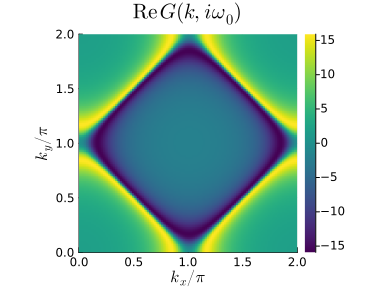

In [54]:
myx = (2 .* collect(1:nsize) .- 1) ./ nsize
myy = (2 .* collect(1:nsize) .- 1) ./ nsize
heatmap(myx, myy, real.(gkf0[hnw+1,:,:]), 
    title=latexstring("\\mathrm{Re}\\,G(k,i\\omega_0)"), xlabel=latexstring("k_x/\\pi"), ylabel=latexstring("k_y/\\pi"), 
    c=:viridis, 
    xlim = (0,2), ylim = (0,2), aspect_ratio=1.0, size=(370,300))

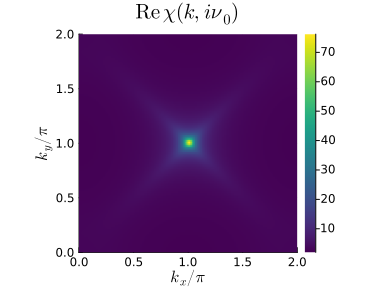

In [55]:
# plot 2D k-dependence of lowest Matsubara frequency of e.g. chi0
myx = (2 .* collect(1:nsize) .- 1) ./ nsize
myy = (2 .* collect(1:nsize) .- 1) ./ nsize
heatmap(myx, myy, real.(chiskf[hnw+1,:,:]),
    title=latexstring("\\mathrm{Re}\\,\\chi(k,i\\nu_0)"), xlabel=latexstring("k_x/\\pi"), ylabel=latexstring("k_y/\\pi"),
    c=:viridis,
    xlim = (0,2), ylim = (0,2), aspect_ratio=1.0, size=(370,300))

In [56]:
chi0kf[hnw+1,nsize÷2+1, nsize÷2+1]

4.692079829394033 + 3.333911824022533e-15im

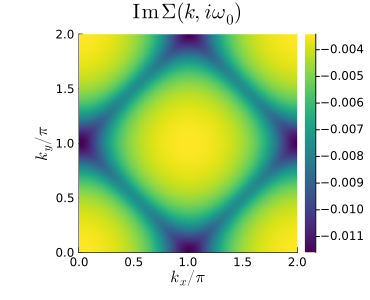

In [57]:
myx = (2 .* collect(1:nsize) .- 1) ./ nsize
myy = (2 .* collect(1:nsize) .- 1) ./ nsize
heatmap(myx, myy, imag.(sekf[hnw+1,:,:]), 
    title=latexstring("\\mathrm{Im}\\,\\Sigma(k,i\\omega_0)"), xlabel=latexstring("k_x/\\pi"), ylabel=latexstring("k_y/\\pi"), 
    c=:viridis, 
    xlim = (0,2), ylim = (0,2), aspect_ratio=1.0, size=(370,300))

In [58]:
#smpl_wn_b = SparseIR.default_matsubara_sampling_points(basis.basis_b)
#smpl_wn_b = smpl_wn_b[smpl_wn_b .!= BosonicFreq(0)]
#smpl_wn_b_wo_zero = MatsubaraSampling(basis.basis_b, smpl_wn_b)
;

In [59]:
chisf = chi0kf[:,nsize÷2+1, nsize÷2+1]
#deleteat!(chisf, hnw+1)
#chisl = fit(smpl_wn_b_wo_zero, chisf, dim=1)
#chisf[37] = 0
chisl = fit(basis.smpl_wn_b, chisf, dim=1)
;

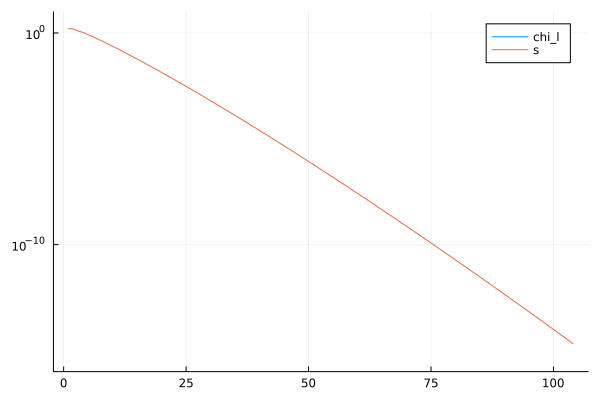

In [60]:
plot(yaxis=:log,ylims=(1e-16,10))
#plot()
plot!(real.(chisl),label="chi_l")
plot!(real.(basis.basis_b.s),label="s")

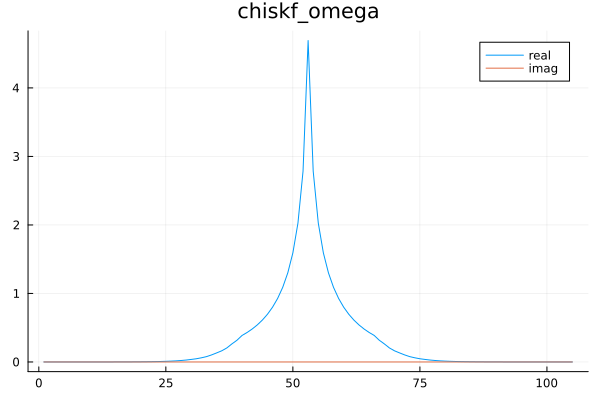

In [61]:
plot(title="chiskf_omega")
plot!(real.(chisf), label="real")
plot!(imag.(chisf), label="imag")

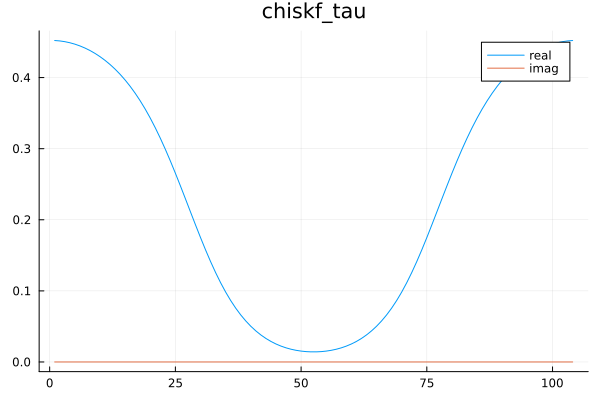

In [62]:
chist = evaluate(basis.smpl_tau_b, chisl)
plot(title="chiskf_tau")
plot!(real.(chist[:]), label="real")
plot!(imag.(chist[:]), label="imag")

In [63]:
chisw = evaluate(basis.smpl_wn_f, chisl)
;

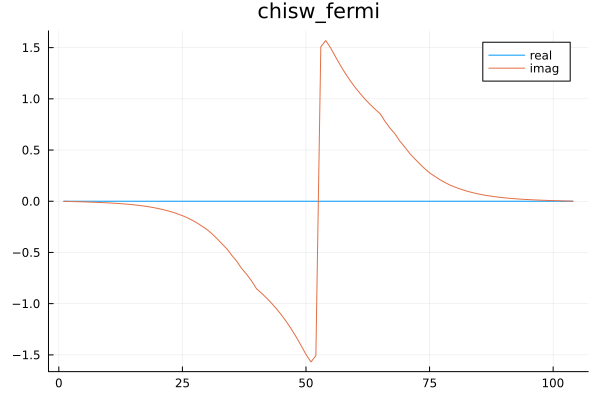

In [64]:
plot(title="chisw_fermi")
plot!(real.(chisw[:]), label="real")
plot!(imag.(chisw[:]), label="imag")

In [79]:
f = open( "FLEX_chi0.dat", "w")
println(f, "$sum_rule")
for iw in 1:hnw
    omega = imag(SparseIR.valueim(basis.smpl_wn_f.sampling_points[hnw+iw], SparseIR.β(basis)))
    chi = chisw[hnw+iw]
    println(f, "$omega \t $(real(chi)) \t $(imag(chi))")
end
close(f)
;

In [65]:
sum_rule::Float64 = real(dot(basis.basis_f.u(SparseIR.β(basis)), chisl) + dot(basis.basis_f.u(0), chisl))

0.9044993479645007

In [66]:
setprecision(512)

512

In [67]:
input_chi  = Array{Complex{T}}(undef, hnw) 
input_smpl = Array{Complex{T}}(undef, hnw) 
;

In [68]:
for i in 1:hnw
    input_smpl[i] = SparseIR.valueim(basis.smpl_wn_f.sampling_points[hnw+i], SparseIR.β(basis))
    input_chi[i]  = -chisw[hnw+i]
end

In [69]:
N_real    =  6000
eta       =  0.001
omega_max =  1.0+eta
H_max     =  50
ab_coeff  = zeros(ComplexF64, 2*H_max) 
lambda    = 1e-5
#1000 → 2000
iter_tol  = 10000
N_imag    =  Nevanlinna.calc_opt_N_imag(hnw, input_smpl, input_chi)
#N_imag = hnw 
println("N_imag $(N_imag)")

N_imag is setted as 22
N_imag 22


In [40]:
@time sol = Nevanlinna.NevanlinnaSolver(N_imag, input_smpl, input_chi, N_real, omega_max, eta, sum_rule, H_max, iter_tol, lambda, true)
;

Pick matrix is non positive semi-definite matrix in Schur method.
H=1
Iter     Function value   Gradient norm 
     0     7.692319e+00     3.610791e+01
 * time: 0.01637411117553711
     1     5.959521e+00     1.376888e+01
 * time: 5.832335948944092
     2     3.237334e+00     8.330503e+00
 * time: 9.7257719039917
     3     2.580651e+00     2.308128e+00
 * time: 11.68789792060852
     4     2.553472e+00     2.065056e-01
 * time: 13.637442111968994
     5     2.553353e+00     1.044147e-01
 * time: 14.896047115325928
     6     2.553319e+00     8.362800e-03
 * time: 16.168946981430054
     7     2.553318e+00     4.325013e-03
 * time: 18.107789993286133
     8     2.553318e+00     3.286115e-03
 * time: 19.3800630569458
     9     2.553318e+00     6.683691e-04
 * time: 20.666630029678345
    10     2.553318e+00     2.367071e-04
 * time: 22.006797075271606
    11     2.553318e+00     1.670284e-04
 * time: 23.893304109573364
    12     2.553318e+00     6.386005e-05
 * time: 25.23860192298889

In [41]:
@time Nevanlinna.solve!(sol)
;

H=1
Iter     Function value   Gradient norm 
     0     2.553318e+00     1.000847e-08
 * time: 0.0002009868621826172
     1     2.553318e+00     1.348790e-08
 * time: 1.248737096786499
     2     2.553318e+00     7.680359e-09
 * time: 2.5294790267944336
max_theta=0.255842386920734370004563853911877928782452084639885716857863251121064675121182769863549230087663306132249825535280713934046959677407336899136834495365516875
hardy optimization was success.
H=2
Iter     Function value   Gradient norm 
     0     2.553318e+00     1.365707e+01
 * time: 0.00019598007202148438
     1     1.994574e+00     1.128237e+01
 * time: 5.025259971618652
     2     6.785222e-01     3.574534e+00
 * time: 7.84345006942749
     3     6.427173e-01     2.790530e+00
 * time: 9.965175867080688
     4     9.266554e-02     2.505030e+00
 * time: 12.101970911026001
     5     6.704932e-02     3.796254e-02
 * time: 14.268976926803589
     6     6.679684e-02     2.688488e-02
 * time: 16.341472864151
     7     6.678261e

LoadError: InterruptException:

In [46]:
imaginary = Nevanlinna.ImagDomainData(input_smpl, input_chi, N_imag)
raw_reals = Nevanlinna.RealDomainData(N_real, omega_max, eta, sum_rule, T=T)
println(typeof(imaginary))
println(typeof(raw_reals))

phis = Nevanlinna.calc_phis(imaginary)
abcd = Nevanlinna.calc_abcd(imaginary, raw_reals, phis)
hardy_matrix = Nevanlinna.calc_hardy_matrix(raw_reals, H_max)

Nevanlinna.evaluation!(raw_reals, abcd, H_max, ab_coeff, hardy_matrix)

Pick matrix is positive semi-definite.
ImagDomainData{BigFloat}
RealDomainData{BigFloat}
max_theta=0.0
hardy optimization was success.


true

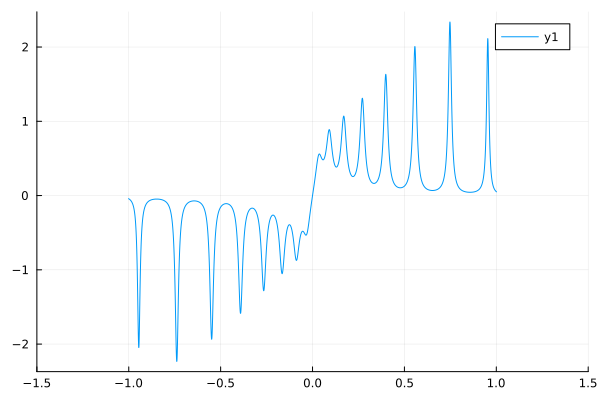

In [47]:
plot(xlim = [-1.5,1.5])
plot!(real.(raw_reals.freq), imag.(raw_reals.val/pi).*tanh.(0.5*SparseIR.β(basis)*real.(raw_reals.freq)))
#plot!(real.(sol.reals.freq), imag.(sol.reals.val/pi).*tanh.(0.5*SparseIR.β(basis)*real.(raw_reals.freq)))

In [81]:
plot(xlim = [-1.5,1.5])
plot!(real.(raw_reals.freq), imag.(raw_reals.val/pi).*tanh.(0.5*SparseIR.β(basis)*real.(raw_reals.freq)),label="non-opt")
plot!(Float64.(real.((sol.reals.freq))), Float64.(imag.(sol.reals.val/pi)).*tanh.(0.5*SparseIR.β(basis)*real.(sol.reals.freq)),label="opt")

LoadError: type SingleSCFSolution has no field reals

In [ ]:
plot(xlim = [-1.5,1.5])
plot!(real.(raw_reals.freq), imag.(raw_reals.val/pi),marker=:+)
plot!(Float64.(real.((sol.reals.freq))), Float64.(imag.(sol.reals.val/pi)))

In [33]:
ComplexF64.(raw_reals.freq[1])

-1.001 + 0.001im